# Data

## File Descriptions

* **sales_train** - The training set. Daily historical data from Jan 2013 to Oct 2015
* **test** - The test set. You need to forecast the sales for these shops and products for Nov 2015
* **items** - Supplemental Information about the items/products.
* **item_categories** - Supplemental information about the items categories
* **shops** - Supplemental information about the shops

## Data Fields

* **ID** - Represents a (Shop, Item) tuple within the test set
* **shop_id** - unique identifier of a shop
* **item_id** - unique identifier of a product
* **item_category_id** - unique identifier of a product
* **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
* **item_price** - current price of an item
* **date** - date in format dd/mm/yyyy
* **date_block_num** - a consecutive month number, used for convenience. Jan 2013 is 0, Feb 2013 is 1, ... , Oct 2015 is 33
* **item_name** - name of item
* **shop_name** - name of shop
* **item_category_name** - name of item category

# Packages

In [1]:
import numpy as np
import pandas as pd
import random as rd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


from itertools import product
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)

# Load Data

In [2]:
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
train = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

# Part1. EDA

## Train

In [3]:
print(train.shape)
train.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
pd.set_option('float_format', '{:f}'.format)
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000
mean,14.569911,33.001728,10197.227057,890.853233,1.242641
std,9.422988,16.226973,6324.297354,1729.799631,2.618834
min,0.000000,0.000000,0.000000,-1.000000,-22.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000
max,33.000000,59.000000,22169.000000,307980.000000,2169.000000


## Outlier Check

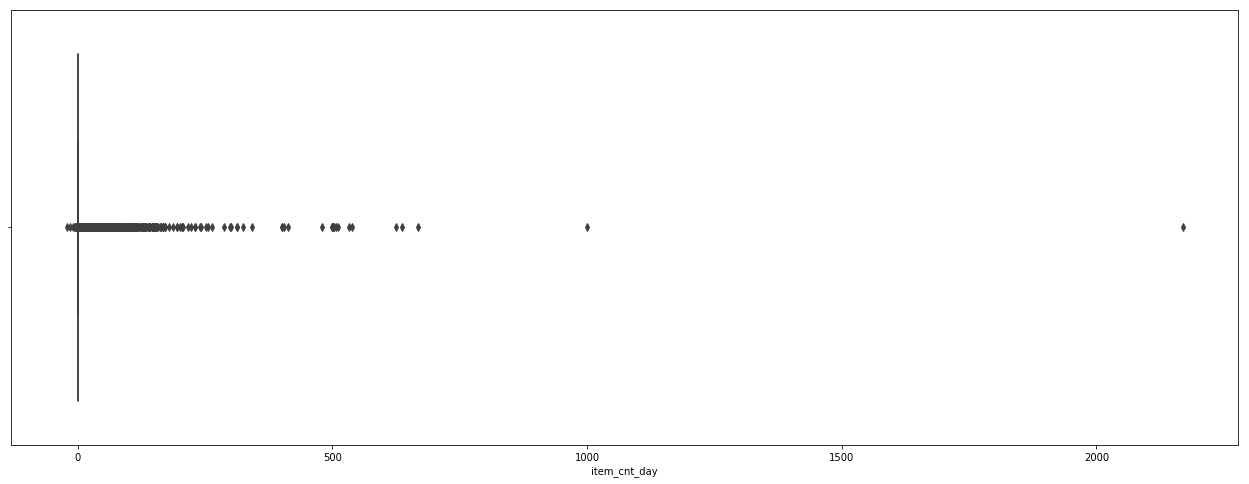

In [5]:
plt.subplots(figsize=(22,8))
sns.boxplot(train['item_cnt_day'])
plt.show()

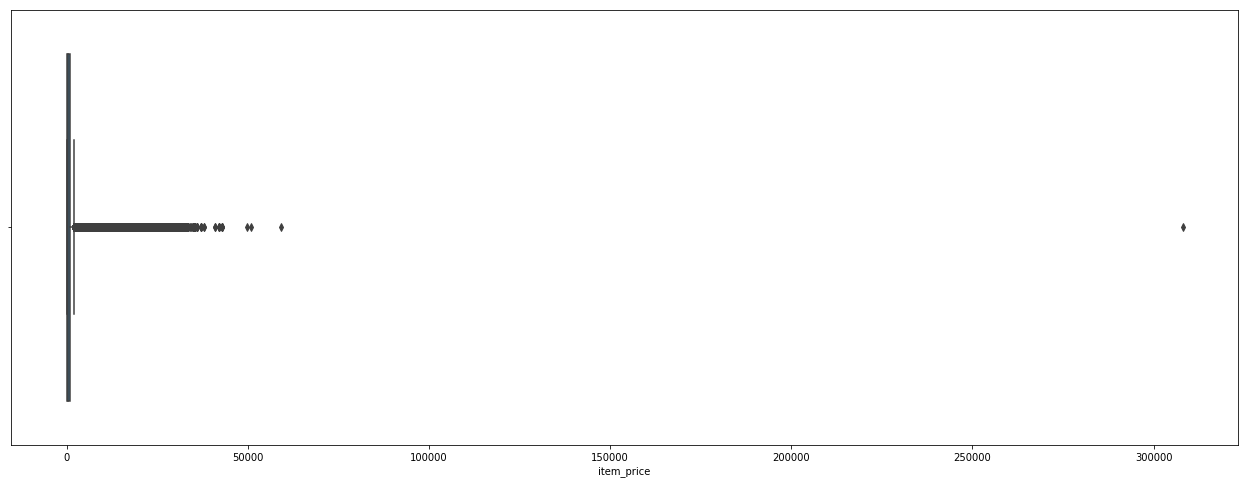

In [6]:
plt.subplots(figsize=(22,8))
sns.boxplot(train['item_price'])
plt.show()

In [7]:
print("The Outlier of the item price is :", train['item_price'].max())
print("The Outlier of the number of product sold per day is :", train['item_cnt_day'].max())

The Outlier of the item price is : 307980.0
The Outlier of the number of product sold per day is : 2169.0


### Item Price

In [8]:
print(train['item_price'].min())
print(train['item_price'].max())
train[train['item_price'].isnull()]

-1.0
307980.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [9]:
 train[train['item_price'] == -1] # missing data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.000000,1.000000


In [10]:
train['item_price'] = train['item_price'].replace(-1, np.nan)
train[train['item_price'] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [11]:
train[train['item_price']==307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.000000,1.000000


In [12]:
train['item_price'] = train['item_price'].replace(307980, np.nan)
train[train['item_price']==307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


## Item_cnt_day

In [13]:
train[train['item_cnt_day']<0].shape

(7356, 6)

In [14]:
train[train['item_cnt_day']<-1].shape

(104, 6)

In [15]:
train.loc[train['item_cnt_day'] < 0, 'item_cnt_day'] = 0

train[train['item_cnt_day']<0]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [16]:
train = train[train['item_cnt_day'] < 1000]

In [17]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935847.000000,2935847.000000,2935847.000000,2935845.000000,2935847.000000
mean,14.569902,33.001743,10197.222994,890.749542,1.244131
std,9.422983,16.226969,6324.296358,1720.490776,2.215524
min,0.000000,0.000000,0.000000,0.070000,0.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000
max,33.000000,59.000000,22169.000000,59200.000000,669.000000


## date

In [18]:
train['date'] = pd.to_datetime(train["date"])

train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [19]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1.000000
1,2013-03-01,0,25,2552,899.000000,1.000000
2,2013-05-01,0,25,2552,899.000000,0.000000
3,2013-06-01,0,25,2554,1709.050000,1.000000
4,2013-01-15,0,25,2555,1099.000000,1.000000


In [20]:
train['date_year'] = train['date'].dt.year
train['date_month'] = train['date'].dt.month
train['date_day'] = train['date'].dt.day

print(train.shape)

train[['date','date_year','date_month','date_day']].head()

(2935847, 9)


,date,date_year,date_month,date_day
0,2013-02-01,2013,2,1
1,2013-03-01,2013,3,1
2,2013-05-01,2013,5,1
3,2013-06-01,2013,6,1
4,2013-01-15,2013,1,15


In [21]:
train[['date','date_block_num']].head(10) 

,date,date_block_num
0,2013-02-01,0
1,2013-03-01,0
2,2013-05-01,0
3,2013-06-01,0
4,2013-01-15,0
5,2013-10-01,0
6,2013-02-01,0
7,2013-04-01,0
8,2013-11-01,0
9,2013-03-01,0


Date block number is not matched. Feb 2013 should be 1 and March 2013 should be 2, not 0

In [22]:
train['date_year(str)'] = train['date_year'].astype('str')
train['date_month(str)'] = train['date_month'].astype('str')
train['date_year-month'] = train['date_year(str)'] + '-' + train['date_month(str)']

print(train.shape)

train[['date_year','date_month','date_year-month', 'date_block_num']].head(15)


(2935847, 12)


,date_year,date_month,date_year-month,date_block_num
0,2013,2,2013-2,0
1,2013,3,2013-3,0
2,2013,5,2013-5,0
3,2013,6,2013-6,0
4,2013,1,2013-1,0
5,2013,10,2013-10,0
6,2013,2,2013-2,0
7,2013,4,2013-4,0
8,2013,11,2013-11,0
9,2013,3,2013-3,0


In [23]:
def fix_block_num(raw):
    if raw['date_year'] == 2013:
        return raw['date_month'] - 1
    elif raw['date_year'] == 2014:
        return raw['date_month'] + 11
    elif raw['date_year'] == 2015:
        return raw['date_month'] + 23

In [24]:
train["date_block_num"] = train.apply(fix_block_num, axis=1)

train[['date_year-month','date_block_num']].head(15)

,date_year-month,date_block_num
0,2013-2,1
1,2013-3,2
2,2013-5,4
3,2013-6,5
4,2013-1,0
5,2013-10,9
6,2013-2,1
7,2013-4,3
8,2013-11,10
9,2013-3,2


<Figure size 432x288 with 0 Axes>

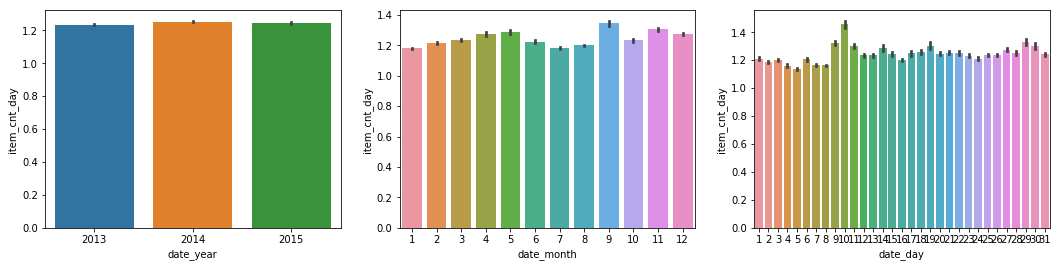

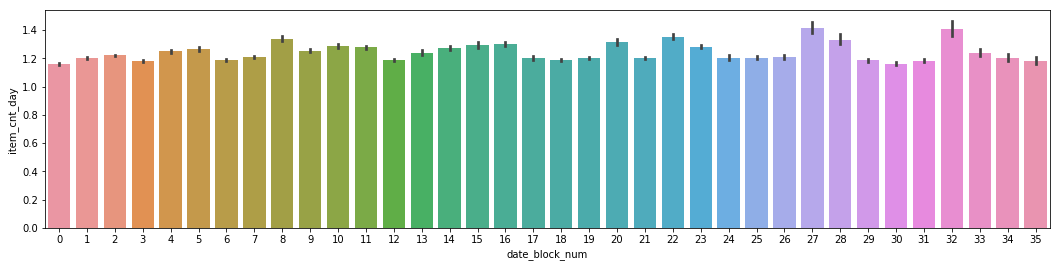

In [25]:
plt.figure()
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,4)
sns.barplot(data=train, x="date_year",y="item_cnt_day", ax=ax1)
sns.barplot(data=train, x="date_month", y="item_cnt_day", ax=ax2)
sns.barplot(data=train, x="date_day", y="item_cnt_day", ax=ax3)

figure, ax4 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18,4)
sns.barplot(data=train, x="date_block_num", y="item_cnt_day", ax=ax4)


In [26]:
# import matplotlib as mpl

# sns.set_style('whitegrid')
# mpl.rc('font', family='Malgun Gothic') ## Mac의 경우는 AppleGothic, 윈도우의 경우는 Malgun Gothic
# mpl.rc('axes', unicode_minus=False)

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('retina')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


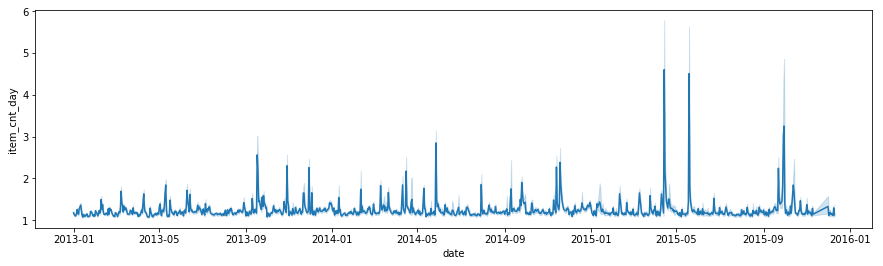

In [27]:
plt.figure(figsize=[15,4])
sns.lineplot(data = train, x='date', y='item_cnt_day')

In [28]:
train[['date','item_cnt_day']].head()

,date,item_cnt_day
0,2013-02-01,1.000000
1,2013-03-01,1.000000
2,2013-05-01,0.000000
3,2013-06-01,1.000000
4,2013-01-15,1.000000


In [29]:
table=pd.pivot_table(data=train,
                    index='date_year',
                    values='item_cnt_day',
                    aggfunc='sum')
table.head()

,item_cnt_day
date_year,
2013,1565897.000000
2014,1323594.000000
2015,763087.000000


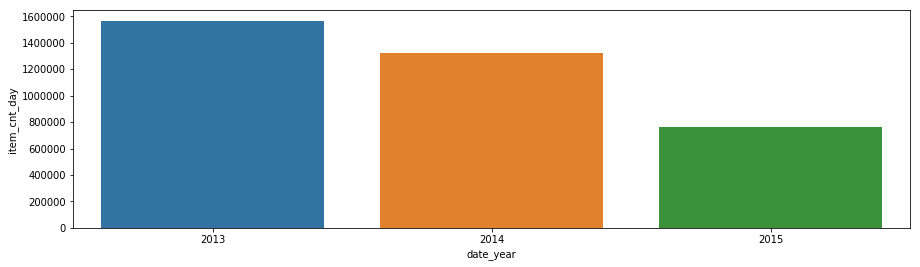

In [30]:
plt.figure(figsize=[15,4])
sns.barplot(data = table, x=table.index, y='item_cnt_day')

In [31]:
table=pd.pivot_table(data=train,
                    index='date_month',
                    values='item_cnt_day',
                    aggfunc='sum')
table.head()

,item_cnt_day
date_month,
1,296350.000000
2,326362.000000
3,329197.000000
4,294880.000000
5,299677.000000


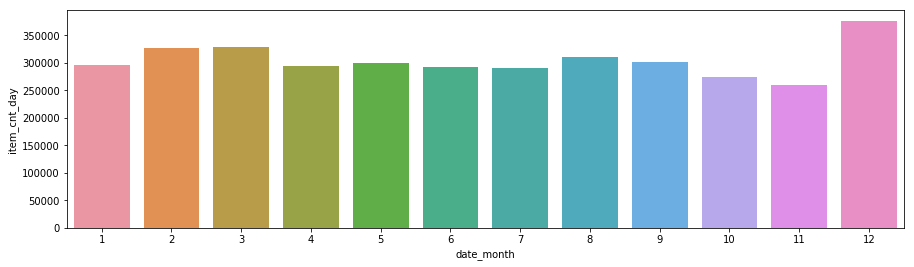

In [32]:
plt.figure(figsize=[15,4])
sns.barplot(data = table, x=table.index, y='item_cnt_day')

In [33]:
table=pd.pivot_table(data=train,
                    index='date_block_num',
                    values='item_cnt_day',
                    aggfunc='sum')
table.head()

,item_cnt_day
date_block_num,
0,117233.000000
1,133938.000000
2,140869.000000
3,112445.000000
4,117024.000000


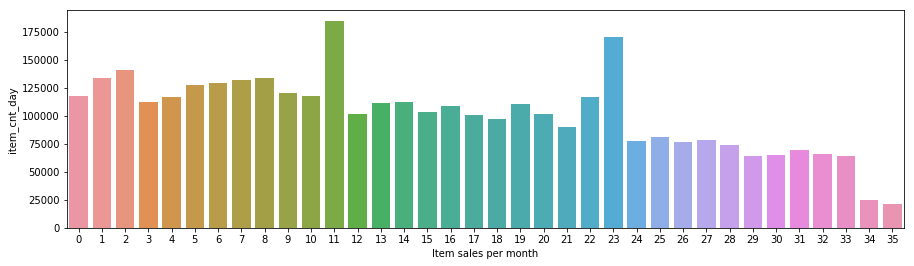

In [34]:
plt.figure(figsize=[15,4])
sns.barplot(data = table, x=table.index, y='item_cnt_day')
plt.xlabel("Item sales per month")
plt.show()

We can see that the total amount of sales per month is declining steadily.The amount of 11 (Dec 2013) and 23(Dec 2014) have peak point, but 35 (Dec 2015) has the lowest point.

In [35]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_year,date_month,date_day,date_year(str),date_month(str),date_year-month
0,2013-02-01,1,59,22154,999.000000,1.000000,2013,2,1,2013,2,2013-2
1,2013-03-01,2,25,2552,899.000000,1.000000,2013,3,1,2013,3,2013-3
2,2013-05-01,4,25,2552,899.000000,0.000000,2013,5,1,2013,5,2013-5
3,2013-06-01,5,25,2554,1709.050000,1.000000,2013,6,1,2013,6,2013-6
4,2013-01-15,0,25,2555,1099.000000,1.000000,2013,1,15,2013,1,2013-1


In [36]:
# unnecessary_cols = ['date_block_num', 'date_day', 'date_year(str)','date_month(str)', 'date_year-month']
# train_ = train.copy()
# train_ = train_.drop('date_block_num', axis=1)
train = train[train['date_block_num'] < 34]
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_year,date_month,date_day,date_year(str),date_month(str),date_year-month
0,2013-02-01,1,59,22154,999.000000,1.000000,2013,2,1,2013,2,2013-2
1,2013-03-01,2,25,2552,899.000000,1.000000,2013,3,1,2013,3,2013-3
2,2013-05-01,4,25,2552,899.000000,0.000000,2013,5,1,2013,5,2013-5
3,2013-06-01,5,25,2554,1709.050000,1.000000,2013,6,1,2013,6,2013-6
4,2013-01-15,0,25,2555,1099.000000,1.000000,2013,1,15,2013,1,2013-1


## Shops

In [37]:
print(shops.shape)
shops.head(10)

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [38]:
pd.set_option('float_format', '{:f}'.format)
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


### Shop ID

Several shops are duplicates of each other (according to its name). Fix train and test

In [39]:
train.loc[train.shop_id==0, 'shop_id'] = 57
test.loc[test.shop_id ==0, 'shop_id']=57

train.loc[train.shop_id ==1, 'shop_id'] = 58
test.loc[test.shop_id ==1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### Shop Name

In [40]:
table = pd.pivot_table(data=shops,
                       index = ['shop_name'],
                       values = 'shop_id',
                      )
table

,shop_id
shop_name,
"!Якутск Орджоникидзе, 56 фран",0
"!Якутск ТЦ ""Центральный"" фран",1
"Адыгея ТЦ ""Мега""",2
"Балашиха ТРК ""Октябрь-Киномир""",3
"Волжский ТЦ ""Волга Молл""",4
"Вологда ТРЦ ""Мармелад""",5
"Воронеж (Плехановская, 13)",6
"Воронеж ТРЦ ""Максимир""",7
"Воронеж ТРЦ Сити-Парк ""Град""",8


The `shop_name` is include city information. We are going to split the informations

In [41]:
from sklearn.preprocessing import LabelEncoder


shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Яку`aтск', 'city' ]='Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('_')
item_categories['type'] = item_categories['split'].map(lambda x:x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])

#if subtype is nana then type
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code','subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)


In [42]:
print(shops.shape)
shops.head()

(60, 2)


,shop_id,city_code
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


## Items & Item Categories

In [43]:
print(item_categories.shape)
item_categories.head()

(84, 3)


,item_category_id,type_code,subtype_code
0,0,0,0
1,1,1,1
2,2,2,2
3,3,3,3
4,4,4,4


In [44]:
pd.set_option('float_format','{:f}'.format)
item_categories.describe()

,item_category_id,type_code,subtype_code
count,84.000000,84.000000,84.000000
mean,41.500000,41.500000,41.500000
std,24.392622,24.392622,24.392622
min,0.000000,0.000000,0.000000
25%,20.750000,20.750000,20.750000
50%,41.500000,41.500000,41.500000
75%,62.250000,62.250000,62.250000
max,83.000000,83.000000,83.000000


In [45]:
print(items.shape)
items.head()

(22170, 2)


,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [46]:
print(items.shape)
items.head()

(22170, 2)


,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [47]:
print(item_categories.shape)
item_categories.head()

(84, 3)


,item_category_id,type_code,subtype_code
0,0,0,0
1,1,1,1
2,2,2,2
3,3,3,3
4,4,4,4


## Sales Product per Month

In [48]:
from itertools import product


df = []
cols = ['date_block_num', 'shop_id','item_id']
for i in range(34):
    sales = train[train['date_block_num'] == i]
    df.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())),dtype = 'int16'))

df_1 = pd.DataFrame(np.vstack(df), columns=cols)
df_1.sort_values(cols, inplace=True)
df_1.head()

,date_block_num,shop_id,item_id
135116,0,2,27
135234,0,2,28
134757,0,2,29
136612,0,2,30
136656,0,2,31


In [49]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [50]:
table = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
table.columns = ['item_cnt_month']
table.reset_index(inplace=True)

df_2 = pd.merge(df_1, table, on=cols, how='left')
df_2['item_cnt_month'] = (df_2['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

In [51]:
df_2.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,0.000000
1,0,2,28,0.000000
2,0,2,29,0.000000
3,0,2,30,1.000000
4,0,2,31,0.000000


According to the `evaluation rule for this competition`, submissions are evaluated by root mean squared error (RMSE) and True target values are clipped into [0,20] range. Therefore, use **clip(0,20)** target value. 

## Test

In [52]:
# test = test.set_index('ID')
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [53]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [54]:
matrix = pd.concat([df_2, test], ignore_index=True, sort=False, keys = cols)
matrix.fillna(0,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,2,27,0.000000,0.000000
1,0,2,28,0.000000,0.000000
2,0,2,29,0.000000,0.000000
3,0,2,30,1.000000,0.000000
4,0,2,31,0.000000,0.000000


In [ ]:
matrix[matrix['date_block_num']==34]

## Shops/Items/Cats features


In [55]:
matrix = pd.merge(df_2, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_categories, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,27,0.000000,1,19,19,19
1,0,2,28,0.000000,1,30,30,30
2,0,2,29,0.000000,1,23,23,23
3,0,2,30,1.000000,1,40,40,40
4,0,2,31,0.000000,1,37,37,37


## Target Lags

In [56]:
def lag_feature(df,lags,col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'shop_id','item_id', col + '_lag_' +str(i)]
        shifted['date_block_num'] +=i
        df = pd.merge(df, shifted, on = ['date_block_num', 'shop_id','item_id'], how='left')
    return df

In [57]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')


## Mean encoded features


In [58]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
group.columns =['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [59]:
group = matrix.groupby(['date_block_num','item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis =1, inplace =True)

In [60]:
group=matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [61]:
group=matrix.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis = 1, inplace =True)


In [62]:
group=matrix.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id','item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis = 1, inplace =True)


In [63]:
group=matrix.groupby(['date_block_num','city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [64]:
group=matrix.groupby(['date_block_num','item_id','city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id','city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [65]:
group=matrix.groupby(['date_block_num','type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [66]:
group=matrix.groupby(['date_block_num','subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

## Price trend

In [67]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559


fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [68]:
group=train.groupby(['date_block_num','shop_id']).agg({'revenue':['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on = ['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue']-matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'],axis=1,inplace=True)

In [69]:
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [70]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = str(row.item_id) + ' ' +str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month !=0:
            cache[key] = row.date_block_num
        else:
            last_date_block_num = cache[key]
            matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

KeyError: '27.0 2.0'

In [71]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

for idx, row in matrix.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month !=0:
            
            cache[key] = row.date_block_num
        else:
            last_date_block_num = cache[key]
            if row.date_block_num > last_date_block_num:
                matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
                cache[key] = row.date_block_num

KeyError: 27.0

In [72]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min') 
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')


In [73]:
matrix = matrix[matrix.date_block_num > 11]


In [74]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)

In [75]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_city_avg_item_cnt_lag_1_x', 'date_city_avg_item_cnt_lag_1_y',
       'date_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
       'delta_price_lag', 'delta_revenue_lag_1', 'month', 'days',
       'item_shop_last_sale', 'item_last_sale', 'item_shop

In [76]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8274100 entries, 5645081 to 13919180
Data columns (total 38 columns):
date_block_num                      int16
shop_id                             int16
item_id                             int16
item_cnt_month                      float16
city_code                           int8
item_category_id                    int8
type_code                           int8
subtype_code                        int8
item_cnt_month_lag_1                float16
item_cnt_month_lag_2                float16
item_cnt_month_lag_3                float16
item_cnt_month_lag_6                float16
item_cnt_month_lag_12               float16
date_avg_item_cnt_lag_1             float16
date_item_avg_item_cnt_lag_1        float16
date_item_avg_item_cnt_lag_2        float16
date_item_avg_item_cnt_lag_3        float16
date_item_avg_item_cnt_lag_6        float16
date_item_avg_item_cnt_lag_12       float16
date_shop_avg_item_cnt_lag_1        float16
date_shop_avg_item

In [78]:
matrix[matrix['date_block_num']==33]

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
13595221,33,2,30,0.000000,1,40,40,40,0.000000,0.000000,...,0.133545,0.133545,-0.591309,-0.136475,9,31,-1,-1,33,33
13595222,33,2,31,1.000000,1,37,37,37,0.000000,0.000000,...,0.115967,0.115967,-0.610352,-0.136475,9,31,-1,-1,33,33
13595223,33,2,32,0.000000,1,40,40,40,0.000000,1.000000,...,0.133545,0.133545,-0.404785,-0.136475,9,31,-1,-1,33,33
13595224,33,2,33,0.000000,1,37,37,37,2.000000,0.000000,...,0.115967,0.115967,-0.214966,-0.136475,9,31,-1,-1,33,33
13595225,33,2,38,0.000000,1,41,41,41,0.000000,0.000000,...,0.085693,0.085693,-0.004284,-0.136475,9,31,-1,-1,21,21
13595226,33,2,40,0.000000,1,57,57,57,0.000000,0.000000,...,0.000000,0.000000,0.000000,nan,9,31,-1,-1,33,33
13595227,33,2,42,0.000000,1,57,57,57,0.000000,0.000000,...,0.063843,0.063843,0.104370,-0.136475,9,31,-1,-1,33,33
13595228,33,2,45,0.000000,1,57,57,57,0.000000,0.000000,...,0.063843,0.063843,0.015282,-0.136475,9,31,-1,-1,33,33
13595229,33,2,49,0.000000,1,57,57,57,0.000000,0.000000,...,0.063843,0.063843,0.103333,-0.136475,9,31,-1,-1,33,33
13595230,33,2,51,0.000000,1,57,57,57,0.000000,0.000000,...,0.063843,0.063843,-0.035767,-0.136475,9,31,-1,-1,33,33


In [ ]:
matrix.to_pickle('data.pkl')
# del matrix
# del cache
# del group
# del items
# del shops
# del item_categories
# del train
# leave test for submission
gc.collect();

# XGBoost

In [ ]:
data = pd.read_pickle('data.pkl')


In [ ]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
#     'date_city_avg_item_cnt_lag_1',
#     'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test

In [ ]:
del data
gc.collect();


In [ ]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [ ]:
X_test.shape

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

In [ ]:
# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [ ]:
plot_features(model, (10,14))

In [ ]:
# columns = ['shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id','date_year', 'date_month', 
#            'date_block_num(clean)', 'city_code', 'type_code','subtype_code']
# unnecessary = set(total_columns) - set(columns)

# unnecessary

In [ ]:
# train = train_raw.drop(unnecessary, axis=1)

# print(train_raw.shape)
# print(train.shape)
# train.head()

In [ ]:
# train.columns

In [ ]:
# train=train[['date_year','date_month','date_block_num(clean)', 'shop_id', 'item_category_id', 'item_id', 
#              'city_code', 'type_code', 'subtype_code','item_price', 'item_cnt_day']]
# train.columns = ['date_year','date_month','date_block_num', 'shop_id', 'item_category_id', 'item_id', 
#              'city_code', 'type_code', 'subtype_code','item_price', 'item_cnt_day']
# train.head()

In [ ]:
# corr = train.corr()

# mask = np.zeros(corr.shape, dtype=bool)
# mask[np.triu_indices(len(mask))] =True
# cmap = sns.diverging_palette(50,10,as_cmap=True)

# fig,ax = plt.subplots(figsize=(10,10))
# sns.heatmap(corr, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
#             square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.75}, mask=mask)
# plt.show()

In [ ]:
# table = pd.pivot_table(data=train,
#                       index = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 
#                                'city_code', 'type_code', 'subtype_code','item_price'],
#                       values = 'item_cnt_day',
#                       aggfunc='sum')
# columns = ['item_cnt_month']
# table.columns = columns
# table = table.reset_index()
# table.head()